## MNIST 손글씨 데이터셋 분류

In [19]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset  # torchvision 이미지인식
import torchvision.transforms as transforms # transforms MNIST 가공 + Tensor형태로 변환.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
mnist_train = dataset.MNIST(root='MNIST_data/',
                          train=True, 
                          transform=transforms.ToTensor(), 
                          download=True) # 6만개 이미지와 레이블

mnist_test = dataset.MNIST(root='MNIST_data/', 
                         train=False, 
                         transform=transforms.ToTensor(), 
                         download=True) # 만개의 미지와 레이블.

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()
5


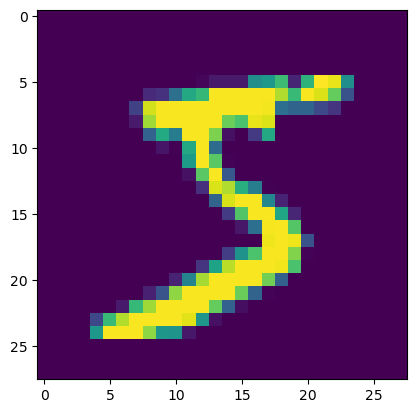

In [21]:
print(mnist_train)
print(mnist_test)
# sample
img, label = mnist_train[0]
plt.imshow(img[0,:,:])
print(label)

In [22]:
# 상대적으로 쉬운 문제이므로 valid_dataset은 따로 상정X
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=32,shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=32,shuffle=False,drop_last=False)

In [23]:
# Neural network 모델만들기
class MNIST_full(nn.Module):
  def __init__(self):
    super(MNIST_full,self).__init__()
    self.lin1 = nn.Linear(784,256)
    self.lin2 = nn.Linear(256,128)
    self.lin3 = nn.Linear(128,10)

  def forward(self,x):
    x = x.view(-1,784)  # (batch, 28, 28, 1) --> (batch, 784) flatten
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = F.softmax(self.lin3(x),dim=1)
    return x

In [24]:
model = MNIST_full()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [25]:
def kl_div(prob1, prob2):
  return torch.sum(prob1*torch.log(prob1/prob2+1e-15))

In [26]:
def cross(prob1,prob2):
  return -torch.sum(prob1*torch.log(prob2))

img, label = mnist_train[0]
y_onehot = torch.zeros(10)
y_onehot[label]=1
y_onehot = y_onehot.view(1,-1)
y_infer = model(img)
print(y_infer)
print(cross(y_onehot,y_infer))

tensor([[0.0963, 0.1024, 0.1012, 0.0973, 0.1109, 0.0989, 0.0983, 0.0944, 0.1008,
         0.0996]], grad_fn=<SoftmaxBackward0>)
tensor(2.3140, grad_fn=<NegBackward0>)


In [27]:
# Train 단계
criterion = nn.CrossEntropyLoss()
for epoch in range(10):
  loss_buffer = []
  for x,y in train_loader: # x: 이미지 y: 레이블(0~9)
    optimizer.zero_grad()    # gradient 0으로 초기화
    
    y_onehot = torch.zeros((y.shape[0],10)) # obe hot encoding
    y_onehot[range(y.shape[0]),y]=1   #one_hot encoding 3 --> [ 0,0,0,1,0,0,0,]
    y_infer = model(x)
    #loss = criterion(y_infer,y)
    loss = kl_div(y_onehot,y_infer) # kl divergence: 확률간 거리. (레이블, 추론)
    loss.backward() #gradient 획득
    optimizer.step() # gradient descent 수행.
    loss_buffer.append(loss.item())

  print('Epoch: {:d}. Train loss {:f}'.format(epoch,np.mean(loss_buffer)))

Epoch: 0. Train loss 17.866371
Epoch: 1. Train loss 8.416638
Epoch: 2. Train loss 6.653440
Epoch: 3. Train loss 5.419057
Epoch: 4. Train loss 4.541780
Epoch: 5. Train loss 3.868781
Epoch: 6. Train loss 3.325493
Epoch: 7. Train loss 2.902229
Epoch: 8. Train loss 2.539666
Epoch: 9. Train loss 2.253255


In [28]:
# Test 단계
acc = []
for x,y in test_loader:
  # one_hot encoding
  y_onehot = torch.zeros((len(y),10))
  y_onehot[range(len(y)),y]=1 # one-hot encoding
  
  y_infer = model(x) #forward propagation

  correct_prediction = torch.argmax(y_infer, 1) == y
  acc.append(correct_prediction.float().mean())
  
print('Test loss {:f}, Accuracy {:f}'.format(np.mean(loss_buffer),np.mean(acc)))

Test loss 2.253255, Accuracy 0.974441


실제 이미지의 숫자 7
예측 이미지의 숫자 tensor([7])


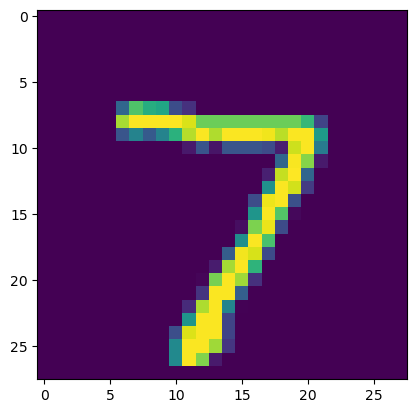

In [29]:
# 실물샘플
img,label=mnist_test[0]
plt.imshow(img[0,:,:])
y_infer = model(img)
print('실제 이미지의 숫자',label)
print('예측 이미지의 숫자',torch.argmax(y_infer,1))